# Monetary policy in HANK

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Monetary policy](#toc2_)    
- 3. [Myopic Agents](#toc3_)    
- 4. [Sticky expectations](#toc4_)    
- 5. [Relax borrowing constraint](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
from HANKModel import HANKModelClass
import numba as nb  

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKModelClass(name='baseline')
model.find_ss(do_print=True)
model._compute_jac_hh()
model.calc_MPC()

 Y =   1.0000
 r    =   0.0050
 A    =   1.2072
 pD    =   1.2072
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
MPC = 0.33, iMPC[0,0] = 0.33
annual_MPC = 0.50


## 2. <a id='toc2_'></a>[Monetary policy](#toc0_)

Create RA model and RA jacobian 

In [3]:
# Copy RA model
model_RA = model.copy()

# Get Jacobian of RA model 
M_RA = model_RA.get_RA_J()

# overwrite HH jacobian such that GEModelTools uses RA jacobian  
for o in ['C_hh', 'A_hh']:
    for i in ['Z', 'ra']:
        model_RA.jac_hh[(o,i)] = M_RA[o][i]

Overwrite HA jacobian with RA jacobian to get RA model (but with same steady state for RA and HA)

In [4]:
for o in ['C_hh', 'A_hh']:
    for i in ['Z', 'ra']:
        model_RA.jac_hh[(o,i)] = M_RA[o][i]

Find Jacobians in HANK and RANK (remember the keyword 'skip_hh=False' in RANK)

In [5]:
model.compute_jacs(skip_hh=False,skip_shocks=False)
model_RA.compute_jacs(skip_hh=True,skip_shocks=False)

Find IRFs

In [6]:
model.find_IRFs(shocks=['eps_i'],do_print=False)
model_RA.find_IRFs(shocks=['eps_i'],do_print=False)

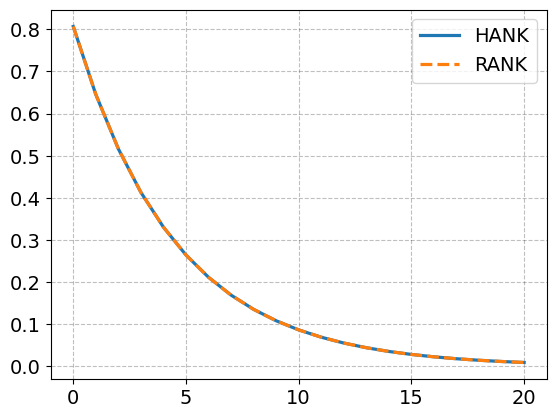

In [7]:
plt.plot(model.IRF['Y'][:21]*100, label='HANK', linewidth=2.3)
plt.plot(model_RA.IRF['Y'][:21]*100, label='RANK', linestyle='--', linewidth=2.3)
plt.legend()
plt.show()

Decompose into **direct** and **indirect** effects using Jacobians (*model.jac_hh*) and IRFs (*model.IRF*)

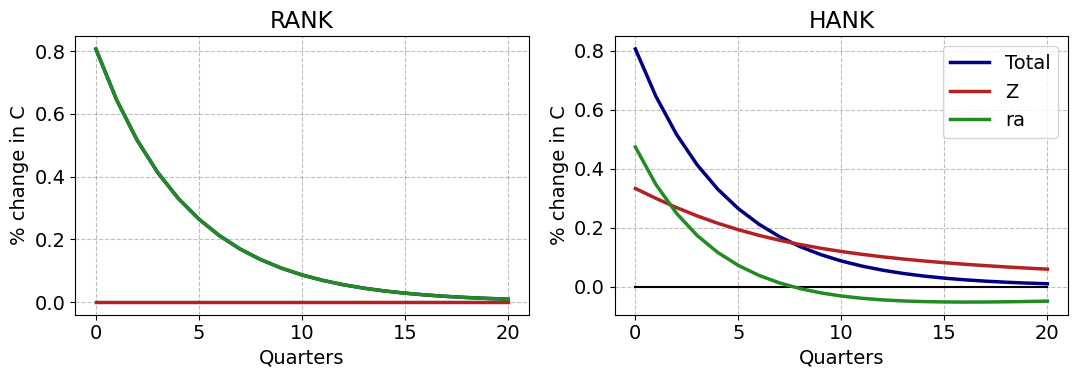

In [8]:
def decomp(model_HA,model_RA, plot_test=False):
    
    # HANK 
    Js_HA = model_HA.jac_hh
    dC_dZ_HA = Js_HA[('C_hh', 'Z')] @ model_HA.IRF['Z']*100/model_HA.ss.C_hh
    dC_dra_HA = Js_HA[('C_hh', 'ra')] @ model_HA.IRF['ra']*100/model_HA.ss.C_hh
    dC_test_HA = dC_dZ_HA + dC_dra_HA
    dC_tot_HA = model_HA.IRF['C_hh']/model_HA.ss.C_hh*100

    # RANK 
    Js_RA = model_RA.jac_hh
    dC_dZ_RA = Js_RA[('C_hh', 'Z')] @ model_RA.IRF['Z']*100/model_RA.ss.C_hh
    dC_dra_RA = Js_RA[('C_hh', 'ra')] @ model_RA.IRF['ra']*100/model_RA.ss.C_hh
    dC_test_RA = dC_dZ_RA + dC_dra_RA
    dC_tot_RA = model_RA.IRF['C_hh']/model_RA.ss.C_hh*100

    # PLOT  
    lw = 2.5
    colors = ['navy', 'firebrick', 'forestgreen', 'orange']

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # Plot RANK 
    axes[0].plot(np.zeros(21), color='black')
    axes[0].plot(dC_tot_RA[:21], linewidth=lw, color=colors[0])
    axes[0].plot(dC_dZ_RA[:21], label='Z', linewidth=lw, color=colors[1])
    axes[0].plot(dC_dra_RA[:21], label='ra', linewidth=lw, color=colors[2])
    if plot_test: axes[0].plot(dC_test_RA[:21], label='Test', linestyle='--', color='orange')
    axes[0].set_title('RANK')
    axes[0].set_xlabel('Quarters')
    axes[0].set_ylabel('% change in C') 

    # Plot HANK
    axes[1].plot(np.zeros(21), color='black')
    axes[1].plot(dC_tot_HA[:21], label='Total', linewidth=lw, color=colors[0])
    if plot_test: axes[1].plot(dC_test_HA[:21], label='Test', linestyle='--', color='orange')
    axes[1].plot(dC_dZ_HA[:21], label='Z', linewidth=lw, color=colors[1])
    axes[1].plot(dC_dra_HA[:21], label='ra', linewidth=lw, color=colors[2])
    axes[1].set_title('HANK')
    axes[1].set_xlabel('Quarters')
    axes[1].set_ylabel('% change in C') 

    
    axes[1].legend()
    plt.tight_layout()
    plt.show()


decomp(model,model_RA, plot_test=False)

Note that the GEModelTools function *model.decompose_hh_path()* decomposes the effects on household aggregates (C,A) *non-linearly* (i.e. does not use the Jacobians) and so should **NOT** be used here.

## 3. <a id='toc3_'></a>[Myopic Agents](#toc0_)

Function to create alternative jacobian M given expectations matrix E

In [9]:
@nb.njit
def create_alt_M(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh


Define function that automatically solve HANK and RANK models for monetary policy shock given **E**

In [10]:
def solve_alt_exp(model,model_RA, E, sticky_vars=['Z','ra']):

    # Copy models 
    model_sticky = model.copy()
    model_sticky_RA = model_RA.copy()

    # Modify Jacobian 
    for o in ['C_hh', 'A_hh']:
        for i in sticky_vars:
            model_sticky.jac_hh[(o,i)] = create_alt_M(model.jac_hh[(o,i)].copy(), E)  
            model_sticky_RA.jac_hh[(o,i)] = create_alt_M(model_RA.jac_hh[(o,i)].copy(), E)   
    
    print(f'Alternative expectations applied w.r.t {sticky_vars}')

    model_sticky.compute_jacs(skip_hh=True,skip_shocks=False)
    model_sticky_RA.compute_jacs(skip_hh=True,skip_shocks=False)

    model_sticky.find_IRFs(shocks=['eps_i'],do_print=False)
    model_sticky_RA.find_IRFs(shocks=['eps_i'],do_print=False)


    plt.plot(model.IRF['Y'][:21]*100, label='HANK', linewidth=2.3, color='navy')
    plt.plot(model_RA.IRF['Y'][:21]*100, label='RANK', linestyle='-', linewidth=2.3, color='firebrick')
    plt.plot(model_sticky.IRF['Y'][:21]*100, label='HANK - Alt. E', linestyle='--', linewidth=2.3, color='navy')
    plt.plot(model_sticky_RA.IRF['Y'][:21]*100, label='RANK - Alt. E', linestyle='--', linewidth=2.3, color='firebrick')
    plt.legend()
    plt.show()


Alternative expectations applied w.r.t ['Z', 'ra']


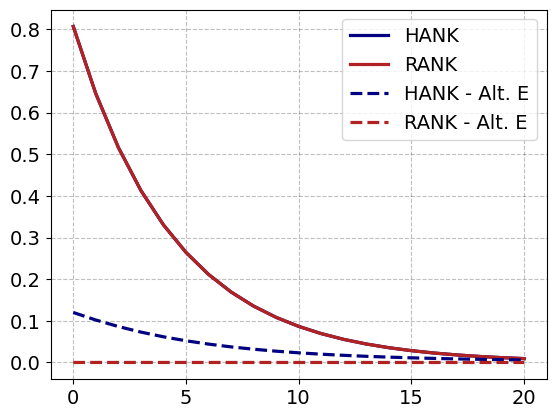

Alternative expectations applied w.r.t ['ra']


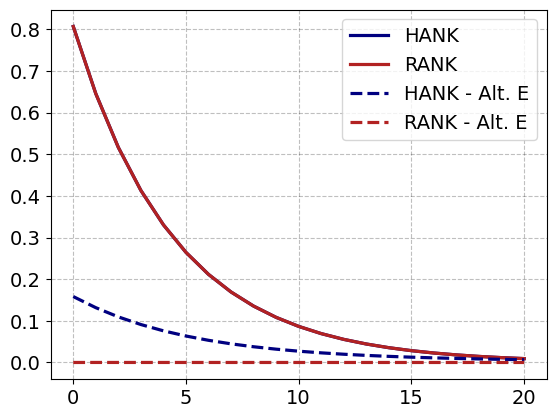

Alternative expectations applied w.r.t ['Z']


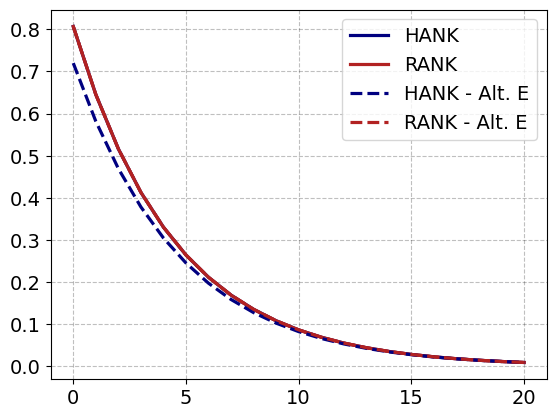

In [11]:
E_myopic = np.ones((model.par.T, model.par.T), dtype=int)
E_myopic[np.triu_indices(model.par.T, 1)] = 0

solve_alt_exp(model,model_RA, E_myopic, sticky_vars=['Z','ra'])
solve_alt_exp(model,model_RA, E_myopic, sticky_vars=['ra'])
solve_alt_exp(model,model_RA, E_myopic, sticky_vars=['Z'])

## 4. <a id='toc4_'></a>[Sticky expectations](#toc0_)

We assume households have sticky expectations w.r.t aggregates. Only a random fraction $1-\theta$ of households update their information set about the aggregate economy, hence learning about the MIT shock. 

The expectation matrix $\bf{E}$ is then given by:
\begin{gather*}
\bf{E}=\left(\begin{array}{cccc}
1 & 1-\theta & 1-\theta & \cdots\\
1 & 1 & \left(1-\theta\right)^{2} & \cdots\\
1 & 1 & 1 & \cdots\\
\vdots & \vdots & \vdots & \ddots
\end{array}\right)
\end{gather*}
where we have ones on and below the diagonal since agents have perfect information w.r.t the current period aggregates. This ensures that they never violate their budget constraints. We set $\theta=0.935$ following the estimates in Auclert et al. (2020).

In [12]:
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))
    return E 

# Create expectations matrix 
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

Alternative expectations applied w.r.t ['Z', 'ra']


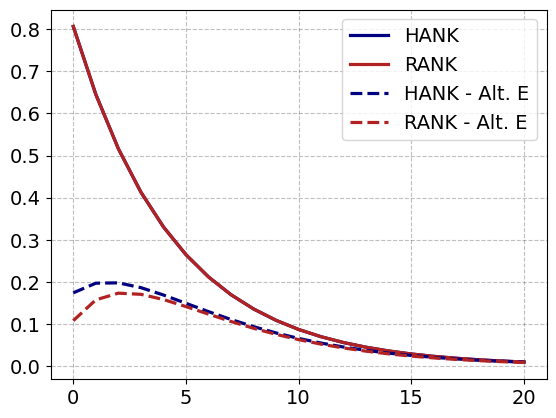

Alternative expectations applied w.r.t ['ra']


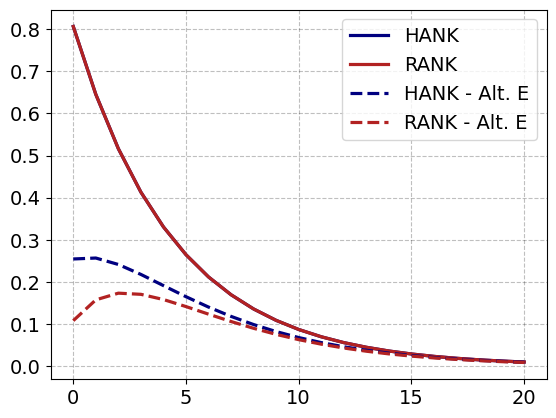

Alternative expectations applied w.r.t ['Z']


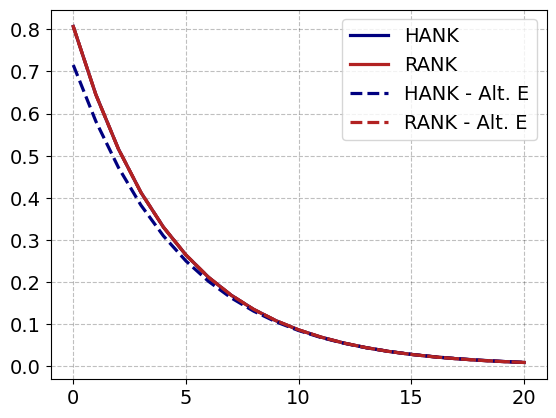

In [13]:
solve_alt_exp(model,model_RA, E_sticky, sticky_vars=['Z','ra'])
solve_alt_exp(model,model_RA, E_sticky, sticky_vars=['ra'])
solve_alt_exp(model,model_RA, E_sticky, sticky_vars=['Z'])

## 5. <a id='toc5_'></a>[Relax borrowing constraint](#toc0_)

In [14]:
model_B = HANKModelClass(name='baseline')
model_B.par.do_B = True
model_B.find_ss(do_print=True)
model_B._compute_jac_hh()
model_B.calc_MPC()

model_B.compute_jacs(skip_hh=False,skip_shocks=False)
model_B.find_IRFs(shocks=['eps_i'],do_print=False)

model_B_debt = HANKModelClass(name='baseline')
model_B_debt.par.a_min = -1.  
model_B_debt.par.do_B = True
model_B_debt.find_ss(do_print=True)
model_B_debt._compute_jac_hh()
model_B_debt.calc_MPC()

model_B_debt.compute_jacs(skip_hh=False,skip_shocks=False)
model_B_debt.find_IRFs(shocks=['eps_i'],do_print=False)

 Y =   1.0000
 r    =   0.0050
 A    =   1.2121
 pD    =   0.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
MPC = 0.33, iMPC[0,0] = 0.33
annual_MPC = 0.50
 Y =   1.0000
 r    =   0.0050
 A    =   0.2120
 pD    =   0.0000
Discrepancy in A =   0.00000002
Discrepancy in Y =  -0.00000000
MPC = 0.33, iMPC[0,0] = 0.33
annual_MPC = 0.50


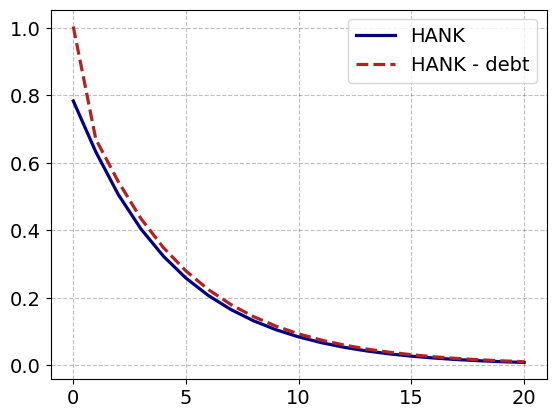

In [15]:
plt.plot(model_B.IRF['Y'][:21]*100, label='HANK', linewidth=2.3, color='navy')
plt.plot(model_B_debt.IRF['Y'][:21]*100, label='HANK - debt', linestyle='--', linewidth=2.3, color='firebrick')
plt.legend()
plt.show()

Decompose into direct and and indirect effects *including* capital gain effects

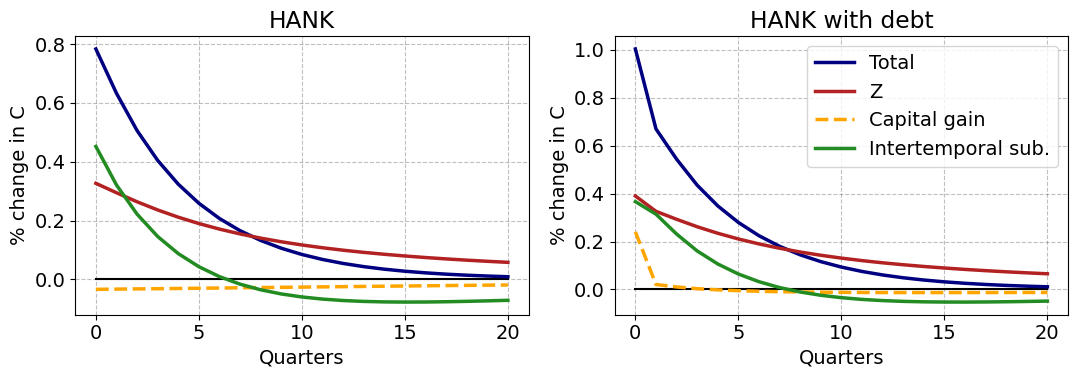

In [16]:
def decomp_HANK(models): 
    model, model_debt = models # HANK NEEDS TO BE FIRST HERE 
    
    # Overall r effect
    decomp = {'base' : {}, 'debt' : {}}
    for modelname in decomp:

        if modelname == 'base':
            model_ = model
        else:
            model_ = model_debt

        Js = model_.jac_hh
        decomp[modelname]['dC_dZ'] = Js[('C_hh', 'Z')] @ model_.IRF['Z']*100/model_.ss.C_hh
        decomp[modelname]['dC_dra']  = Js[('C_hh', 'ra')] @ model_.IRF['ra']*100/model_.ss.C_hh

        decomp[modelname]['dC_tot'] = model_.IRF['C_hh']/model_.ss.C_hh*100

        # Split into intertemporal sub + capital gain 
        dra = model_.IRF['ra']
        decomp[modelname]['dC_dcap'] = Js[('C_hh', 'ra')][:, 0] * dra[0] * 100/model_.ss.C_hh
        decomp[modelname]['dC_dr'] = Js[('C_hh', 'ra')][:, 1:] @ dra[1:] * 100/model_.ss.C_hh

    # plot 
    lw = 2.5
    colors = ['navy', 'firebrick', 'forestgreen', 'orange']
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # Plot data on the first subplot
    axes[0].plot(np.zeros(21), color='black')
    axes[0].plot(decomp['base']['dC_tot'][:21], label='Total', linewidth=lw, color=colors[0])
    axes[0].plot(decomp['base']['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
    axes[0].plot(decomp['base']['dC_dcap'][:21], label='Capital gain', linewidth=lw, color=colors[3], linestyle='--')
    axes[0].plot(decomp['base']['dC_dr'][:21], label='Intertemporal sub.', linewidth=lw, color=colors[2])
    axes[0].set_title('HANK')
    axes[0].set_xlabel('Quarters')
    axes[0].set_ylabel('% change in C') 

    # Plot data on the second 
    axes[1].plot(np.zeros(21), color='black')
    axes[1].plot(decomp['debt']['dC_tot'][:21], label='Total', linewidth=lw, color=colors[0])
    axes[1].plot(decomp['debt']['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
    axes[1].plot(decomp['debt']['dC_dcap'][:21], label='Capital gain', linewidth=lw, color=colors[3], linestyle='--')
    axes[1].plot(decomp['debt']['dC_dr'][:21], label='Intertemporal sub.', linewidth=lw, color=colors[2])
    axes[1].set_title('HANK with debt')
    axes[1].set_xlabel('Quarters')
    axes[1].set_ylabel('% change in C') 

    # Adjust layout to prevent overlap
    axes[1].legend()
    plt.tight_layout()

    # Show the plots
    plt.show()

decomp_HANK([model_B,model_B_debt])